# Preprocessing steps analysis for Stanford datasets

### Import modules and define methods

In [30]:
%reload_ext autoreload
%autoreload 2

from preprocess import *
from argparse import Namespace
import skimage.exposure as exp
import clahe 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (15, 12)

from tqdm import tqdm_notebook as tqdm
import subtle.subtle_preprocess as supre

metadata={
    'lambda': []
}

def show_img(img, title='', axis=False, vmin=None, vmax=None):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)

def show_gad_comparison(img_pre, img_low, img_post, vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 3, 1)
    show_img(img_pre, title='Pre contrast', vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 2)
    show_img(img_low, title='10% dosage', vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 3)
    show_img(img_post, title='Full dosage', vmin=vmin, vmax=vmax)

    plt.show()

def show_comparison(img1, img2, titles=['', ''], vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 2, 1)
    show_img(img1, title=titles[0], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 2, 2)
    show_img(img2, title=titles[1], vmin=vmin, vmax=vmax)
    
    plt.show()

def iminfo(img):
    print(img.shape, img.dtype, img.min(), img.max(), img.mean())

def diff_img(img1, img2, abs_diff=True):
    diff = np.subtract(img1.astype(np.float32), img2.astype(np.float32))
    if not abs_diff:
        return diff
    
    return np.abs(diff).astype(np.float32)

def show_hist(img, nbins=512, title=''):
    rav = img.ravel()
    rav = rav[rav != 0]
    plt.hist(rav, bins=nbins, log=True)
    plt.title(title)
    plt.xlabel('Pixel values')
    plt.ylabel('log10 Count')
    plt.show()

def show_final_comparison(img_pre, img_low, img_post):
    fig = plt.figure(figsize=(15, 12))
    fig.tight_layout()
    
    imstack = np.hstack((img_pre, img_low, img_post))
    abs_diff = True
    
    scale_factor = 5
    
    diff0 = diff_img(img_pre, img_pre, abs_diff)
    diff1 = diff_img(img_low, img_pre, abs_diff)
    diff2 = diff_img(img_post, img_pre, abs_diff)
    
    diff = np.hstack((diff0, diff1 * scale_factor, diff2 * scale_factor))
    
    final_disp = np.vstack((imstack, diff))
    
    show_img(final_disp, vmin=imstack.min(), vmax=imstack.max())

<Figure size 1080x864 with 0 Axes>

### Initialize dummy argparse Namespace

In [2]:
args = Namespace(
    path_base='/home/srivathsa/projects/studies/gad/stanford/data/Patient_0101', verbose=True,
    output='/home/srivathsa/projects/studies/gad/stanford/preprocess/data/dummy.h5',
    discard_start_percent=0, discard_end_percent=0, normalize=True,
    normalize_fun='mean', transform_type='rigid', scale_matching=True,
    path_zero=None, path_low=None, path_full=None, mask_threshold=0.04,
    override=False, skip_mask=False, scale_dicom_tags=False, skip_hist_norm=False,
    skip_registration=False, nslices=20, joint_normalize=False, global_scale_ref_im0=False, noise_mask_area=False,
    fsl_mask=True, fsl_threshold=0.5
)

### Fetch original images

In [3]:
ims, hdr, metadata = get_images(args, metadata)
orig_ims = np.copy(ims)
pidx = ims.shape[0] // 2

path_zero = /home/srivathsa/projects/studies/gad/stanford/data/Patient_0101/7_Ax_BRAVO_PRE
path_low = /home/srivathsa/projects/studies/gad/stanford/data/Patient_0101/10_Ax_BRAVO+C
path_full = /home/srivathsa/projects/studies/gad/stanford/data/Patient_0101/13_Ax_BRAVO+C
image sizes:  (336, 512, 512) (336, 512, 512) (336, 512, 512)


(336, 512, 512) float32 0.0 12541.0 549.6766
(336, 512, 512) float32 0.0 12381.0 585.20605
(336, 512, 512) float32 0.0 17941.0 855.1929


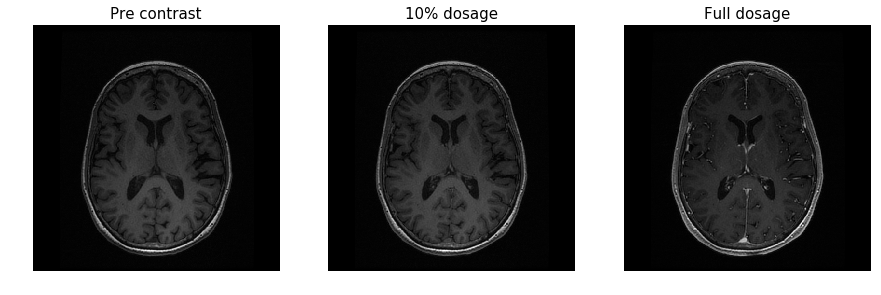

In [4]:
iminfo(ims[:, 0])
iminfo(ims[:, 1])
iminfo(ims[:, 2])

show_gad_comparison(ims[172, 0], ims[172, 1], ims[172, 2])

### Mask images

In [5]:
ims, mask, metadata = mask_images(args, ims, metadata)

masking


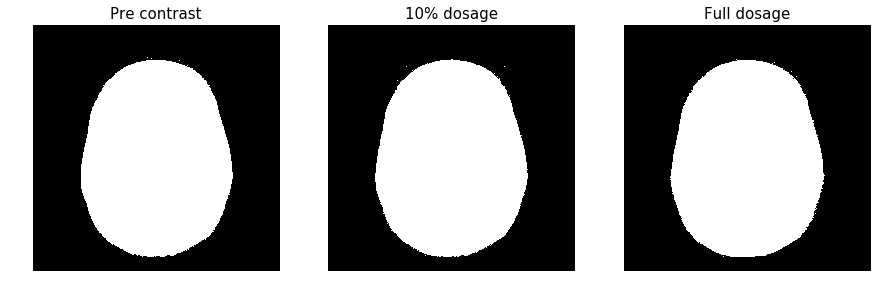

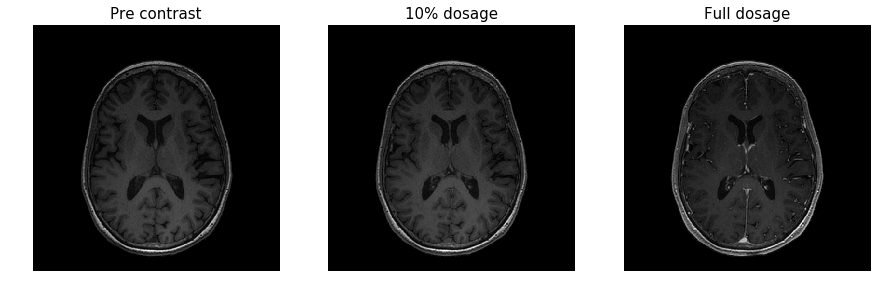

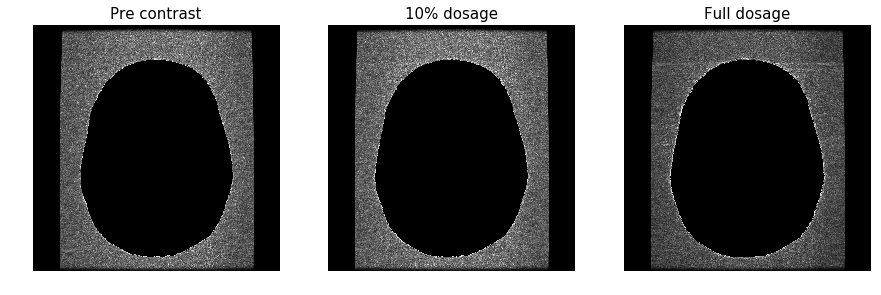

In [6]:
show_gad_comparison(mask[172, 0], mask[172, 1], mask[172, 2])
show_gad_comparison(ims[172, 0], ims[172, 1], ims[172, 2])

pre_diff = diff_img(orig_ims[172, 0], ims[172, 0])
low_diff = diff_img(orig_ims[172, 1], ims[172, 1])
post_diff = diff_img(orig_ims[172, 2], ims[172, 2])

show_gad_comparison(pre_diff, low_diff, post_diff)

### Image registration

In [7]:
orig_ims = np.copy(ims)
ims, metadata = register(args, ims, metadata)

image registration
registration done, 23.4 s
low dose transform parameters: ('-0.00197294', '-0.00112258', '-0.00523559', '-0.363198', '-0.0308714', '0.0893327')
image registration
registration done, 25.2 s
full dose transform parameters: ('-0.00275695', '-0.002764', '0.00248218', '-0.13062', '0.129497', '0.869434')


(512, 512) float32 0.0 11211.0 739.30597
(512, 512) float32 0.0 10892.719 771.4645
(512, 512) float32 -0.0 15628.194 1054.5562


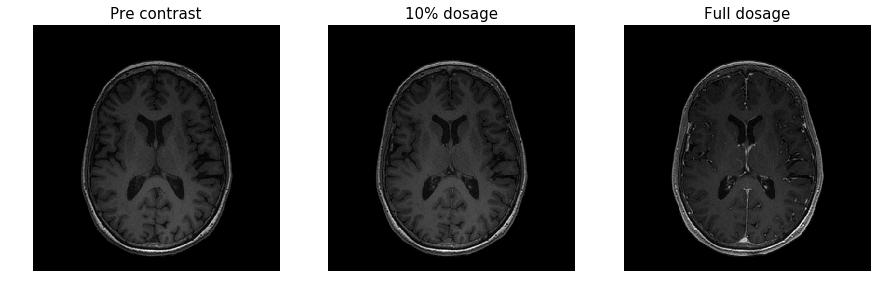

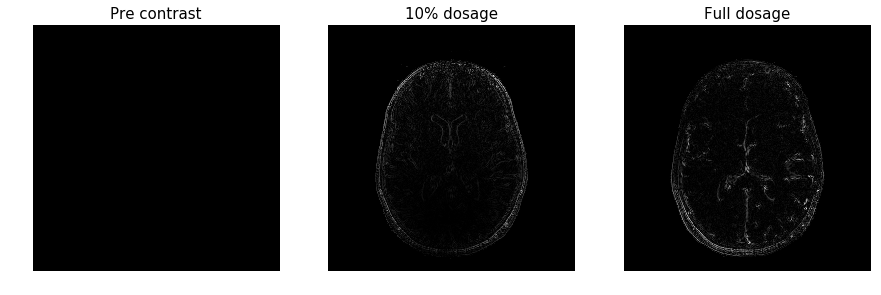

In [8]:
iminfo(ims[172, 0])
iminfo(ims[172, 1])
iminfo(ims[172, 2])

show_gad_comparison(ims[172, 0], ims[172, 1], ims[172, 2])

pre_diff = diff_img(orig_ims[172, 0], ims[172, 0])
low_diff = diff_img(orig_ims[172, 1], ims[172, 1])
post_diff = diff_img(orig_ims[172, 2], ims[172, 2])

show_gad_comparison(pre_diff, low_diff, post_diff)

### FSL Mask

In [9]:
fsl_mask = fsl_brain_mask(args)
ims = apply_fsl_mask(args, ims, fsl_mask)

Extracting brain regions using FSL...
Applying computed FSL masks on images


### Histogram normalization

In [10]:
orig_ims = np.copy(ims)
ims, metadata = hist_norm(args, ims, metadata)

image intensity normalization
scaling done, 3.24 s
image intensity normalization
scaling done, 3.18 s


0.0 0.0


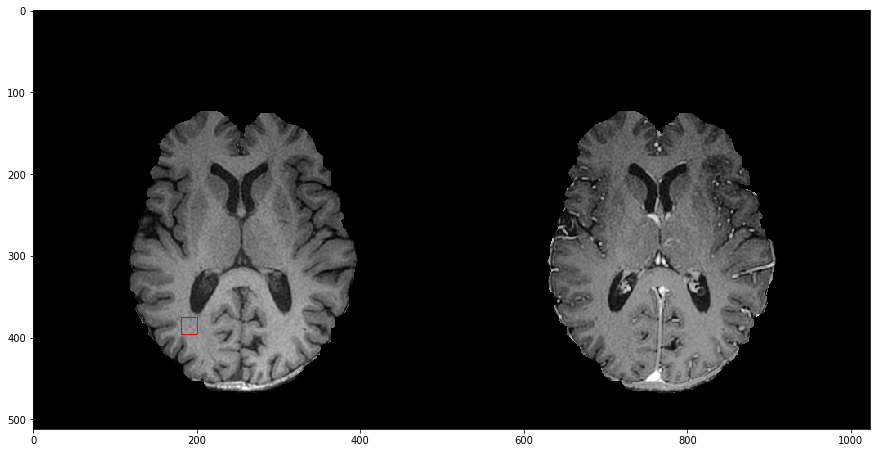

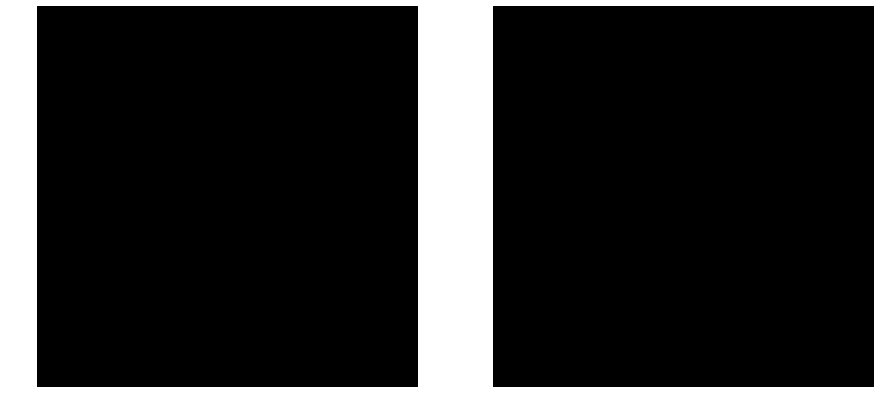

In [51]:
vmin = ims[:, 0].min()
vmax = ims[:, 0].max()

diff = np.abs(ims[:, 0] - ims[:, 2])
vmin, vmax = (diff.min(), diff.max())

th = diff.max() * 0.25
mask = diff >= th

full_masked = (ims[:, 2] * mask)

recon = ims[:, 0] + full_masked

x1=280
x2=340
y1=360
y2=420

im1 = ims[pidx, 0]
im2 = ims[pidx, 1]
im3 = ims[pidx, 2]

stack = np.hstack([im1, im3])

fig, ax = plt.subplots(1)
ax.imshow(stack, vmin=vmin, vmax=vmax)
rect = Rectangle((180, 375), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

p1 = im1[160:180, 355:375]
p2 = im3[160:180, 355:375]

print(p1.mean(), p2.mean())

show_comparison(p1, p2)
#show_comparison(im1, im3, vmin=vmin, vmax=vmax)

In [ ]:
iminfo(ims[172, 0])
iminfo(ims[172, 1])
iminfo(ims[172, 2])

show_gad_comparison(ims[172, 0], ims[172, 1], ims[172, 2])
show_comparison(diff_img(ims[172, 0], ims[172, 1]), diff_img(ims[172, 0], ims[172, 2]))

### Zoom

In [ ]:
args.zoom = 512
args.zoom_order = 1

ims_zoom, metadata = zoom_process(args, ims, metadata)

In [ ]:
iminfo(ims_zoom)
show_gad_comparison(ims_zoom[172, 0], ims_zoom[172, 1], ims_zoom[172, 2])

### Match scales and global normalization

In [ ]:
orig_ims = np.copy(ims)

ims, ims_mod, metadata = prescale_process(args, ims, mask, metadata)
ims, ims_mod, metadata = match_scales(args, ims, ims_mod, metadata)
ims, metadata = global_norm(args, ims, ims_mod, metadata)

In [ ]:
iminfo(ims[:, 0])
iminfo(ims[:, 1])
iminfo(ims[:, 2])

show_gad_comparison(ims[172, 0], ims[172, 1], ims[172, 2])

In [ ]:
show_hist(ims[:, 0], nbins=255, title='Pre contrast')
show_hist(ims[:, 1], nbins=255, title='10% dosage')
show_hist(ims[:, 2], nbins=255, title='Full dosage')

In [ ]:
show_final_comparison(ims[172, 0], ims[172, 1], ims[172, 2])